<a href="https://colab.research.google.com/github/probml/probml-notebooks/blob/main/notebooks/gp_mauna_loa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian process time series forecasting for Mauna Loa CO2

In the following, we'll reproduce the analysis for Figure 5.6 in [Chapter 5 of Rasmussen & Williams (R&W)](http://www.gaussianprocess.org/gpml/chapters/RW5.pdf).

Code is from 
https://tinygp.readthedocs.io/en/latest/tutorials/quickstart.html



In [1]:
try:
    import tinygp
except ImportError:
    !pip install -q tinygp

from jax.config import config

config.update("jax_enable_x64", True)

# Data

The data are measurements of the atmospheric CO2 concentration made at Mauna Loa, Hawaii (Keeling & Whorf 2004).
Data can be found at  http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record. We use the [statsmodels version](http://statsmodels.sourceforge.net/devel/datasets/generated/co2.html].
 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


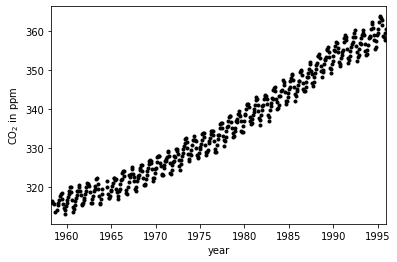

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import co2

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]

plt.plot(t, y, ".k")
plt.xlim(t.min(), t.max())
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")
plt.savefig("gp-mauna-loa-data.pdf")

# Kernel

In this figure, you can see that there is periodic (or quasi-periodic) signal with a year-long period superimposed on a long term trend. We will follow R&W and model these effects non-parametrically using a complicated covariance function. The covariance function that we’ll use is:

$$k(r) = k_1(r) + k_2(r) + k_3(r) + k_4(r)$$

where

$$
\begin{eqnarray}
    k_1(r) &=& \theta_0^2 \, \exp \left(-\frac{r^2}{2\,\theta_1^2} \right) \\
    k_2(r) &=& \theta_2^2 \, \exp \left(-\frac{r^2}{2\,\theta_3^2}
                                         -\theta_5\,\sin^2\left(
                                         \frac{\pi\,r}{\theta_4}\right)
                                        \right) \\
    k_3(r) &=& \theta_6^2 \, \left [ 1 + \frac{r^2}{2\,\theta_7^2\,\theta_8}
                             \right ]^{-\theta_8} \\
    k_4(r) &=& \theta_{9}^2 \, \exp \left(-\frac{r^2}{2\,\theta_{10}^2} \right)
                + \theta_{11}^2\,\delta_{ij}
\end{eqnarray}
$$

We can implement this kernel in `tinygp` as follows (we'll use the R&W results as the hyperparameters for now):

In [8]:
import jax
import jax.numpy as jnp

from tinygp import kernels, transforms, GaussianProcess


def build_gp(theta, X):
    mean = theta[-1]

    # We want most of out parameters to be positive so we take the `exp` here
    # Note that we're using `jnp` instead of `np`
    theta = jnp.exp(theta[:-1])

    # Construct the kernel by multiplying and adding `Kernel` objects
    k1 = theta[0] ** 2 * kernels.ExpSquared(theta[1])
    k2 = theta[2] ** 2 * kernels.ExpSquared(theta[3]) * kernels.ExpSineSquared(period=theta[4], gamma=theta[5])
    k3 = theta[6] ** 2 * kernels.RationalQuadratic(alpha=theta[7], scale=theta[8])
    k4 = theta[9] ** 2 * kernels.ExpSquared(theta[10])
    kernel = k1 + k2 + k3 + k4

    return GaussianProcess(kernel, X, diag=theta[11] ** 2, mean=mean)


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.condition(y)

# Model fitting

In [ ]:
# Objective
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))

# These are the parameters from R&W
mean_output = 340.0
theta_init = np.append(
    np.log([66.0, 67.0, 2.4, 90.0, 1.0, 4.3, 0.66, 1.2, 0.78, 0.18, 1.6, 0.19]),
    mean_output,
)

In [11]:
obj(theta_init, t, y)

(DeviceArray(585.37706269, dtype=float64),
 DeviceArray([-2.58285907e-01,  3.56378508e+00,  1.23388062e+01,
              -5.49784599e+00,  2.47378961e+03,  1.67550159e+01,
              -1.93739004e+01,  1.82885890e+01,  8.83113233e+01,
               1.51907390e-01, -3.30175815e-01, -1.01704645e+03,
              -1.12356739e-02], dtype=float64))



Using our loss function defined above, we'll run a gradient based optimization routine from `scipy` (you could also use a `jax`-specific optimizer, but that's not necessary) to fit this model as follows:

In [12]:
from scipy.optimize import minimize

soln = minimize(obj, theta_init, jac=True, args=(t, y))
print(f"Final negative log likelihood: {soln.fun}")

Final negative log likelihood: 299.249780494596


**Warning:** *An optimization code something like this should work on most problems but the results can be very sensitive to your choice of initialization and algorithm. If the results are nonsense, try choosing a better initial guess or try a different value of the ``method`` parameter in ``op.minimize``.*



# Plot results

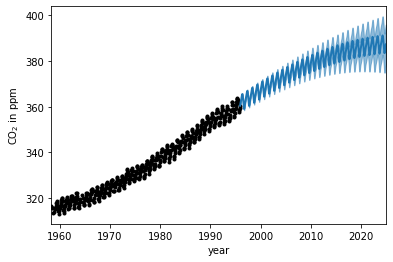

In [16]:
x = np.linspace(max(t), 2025, 2000)
gp = build_gp(soln.x, t)
mu, var = gp.predict(y, x, return_var=True)

plt.plot(t, y, ".k")
plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5)
plt.plot(x, mu, color="C0", lw=2)

plt.xlim(t.min(), 2025)
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")
plt.savefig("gp-mauna-loa-pred.pdf")